# **(Sale Price Correlation Study)**

## Objectives

* Answer BR1, we look how the sales price and attributes coorelates.

## Inputs

* outputs/datasets/cleaned/HousePricesCleaned.csv 

## Outputs

* Generate code for BR1 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/housepricepred2/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/housepricepred2'

## Load Data

In [5]:
import pandas as pd
df = pd.read_csv("outputs/datasets/cleaned/HousePricesCleaned.csv")
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,GarageArea,GarageFinish,GrLivArea,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.000000,No,706,GLQ,150,548,RFn,1710,...,8450,65.0,196.0,61,5,7,856,2003,2003,208500
1,1262,0.0,3.000000,Gd,978,ALQ,284,460,RFn,1262,...,9600,80.0,0.0,0,8,6,1262,1976,1976,181500
2,920,866.0,3.000000,Mn,486,GLQ,434,608,RFn,1786,...,11250,68.0,162.0,42,5,7,920,2001,2002,223500
3,961,0.0,2.869214,No,216,ALQ,540,642,Unf,1717,...,9550,60.0,0.0,35,5,7,756,1915,1970,140000
4,1145,0.0,4.000000,Av,655,GLQ,490,836,RFn,2198,...,14260,84.0,350.0,84,5,8,1145,2000,2000,250000


## Data Exploration

* Before starting we get familiar with our data.

In [6]:
from ydata_profiling import ProfileReport
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Correlation and PPS Analyses

* Identifying Categorical Columns: The code starts by selecting all columns in the DataFrame df that are of the type 'object', which typically represents categorical variables. These columns are stored in the list categorical_cols.

* Initialization of OneHotEncoder: The OneHotEncoder is initialized with two key parameters: variables, which is set to the list of categorical columns, and drop_last, which is set to True. The latter ensures that the last binary column for each categorical variable is dropped to avoid multicollinearity, a common issue in regression models where one variable can be linearly predicted from the others.

* Applying the Encoder: The encoder is then applied to the DataFrame df using the fit_transform method. This method fits the encoder to the DataFrame and transforms the categorical variables into one-hot encoded variables. The result is a new DataFrame df_encoded that contains the original data with categorical variables replaced by their one-hot encoded counterparts.

* Output: Finally, the code prints the shape (dimensions) of the transformed DataFrame df_encoded to give an idea of how many columns have been added through the encoding process. It also displays the first five rows of df_encoded using the head() method to provide a quick glimpse of the transformed data.

In [7]:
from feature_engine.encoding import OneHotEncoder

# Identifying categorical columns in the DataFrame
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Initialize the OneHotEncoder
one_hot_encoder = OneHotEncoder(variables=categorical_cols, drop_last=True)

# Applying the encoder to the DataFrame
df_encoded = one_hot_encoder.fit_transform(df)

# Displaying the dimensions and the first few rows of the transformed DataFrame
print("Shape of DataFrame after One-Hot Encoding:", df_encoded.shape)
df_encoded.head()

Shape of DataFrame after One-Hot Encoding: (1460, 33)


,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtFinSF1,BsmtUnfSF,GarageArea,GrLivArea,LotArea,LotFrontage,MasVnrArea,...,BsmtFinType1_Unf,BsmtFinType1_Rec,BsmtFinType1_BLQ,BsmtFinType1_None,GarageFinish_RFn,GarageFinish_Unf,GarageFinish_Fin,KitchenQual_Gd,KitchenQual_TA,KitchenQual_Ex
0,856,854.0,3.000000,706,150,548,1710,8450,65.0,196.0,...,0,0,0,0,1,0,0,1,0,0
1,1262,0.0,3.000000,978,284,460,1262,9600,80.0,0.0,...,0,0,0,0,1,0,0,0,1,0
2,920,866.0,3.000000,486,434,608,1786,11250,68.0,162.0,...,0,0,0,0,1,0,0,1,0,0
3,961,0.0,2.869214,216,540,642,1717,9550,60.0,0.0,...,0,0,0,0,0,1,0,1,0,0
4,1145,0.0,4.000000,655,490,836,2198,14260,84.0,350.0,...,0,0,0,0,1,0,0,1,0,0


In [27]:
import os
import numpy as np
import ppscore as pps
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def compute_correlations_pps(dataframe):
    """
    Computes Spearman and Pearson correlations, and PPS for the given DataFrame.
    Only numerical columns are considered for correlation calculations.
    """
    # Filter only numerical columns for correlation
    num_df = dataframe.select_dtypes(include=[np.number])

    # Compute Spearman and Pearson correlations on numerical data
    spearman_corr = num_df.corr(method='spearman').rename_axis('Variables', axis=1)
    pearson_corr = num_df.corr(method='pearson').rename_axis('Variables', axis=1)

    # PPS calculation can include non-numerical columns
    pps_scores = pps.matrix(dataframe)[['x', 'y', 'ppscore']].pivot(index='y', columns='x', values='ppscore')

    return spearman_corr, pearson_corr, pps_scores

def show_heatmaps(pearson_corr, spearman_corr, pps_matrix, size, annot_size, corr_thresh, pps_thresh):
    """
    Displays heatmaps for Pearson and Spearman correlations, and PPS.
    """
    def plot_heatmap(matrix, title, color_map, is_pps=False):
        mask = np.triu(np.ones_like(matrix, dtype=bool))
        if is_pps:
            mask = np.zeros_like(matrix, dtype=bool)
        
        plt.figure(figsize=size)
        sns.heatmap(matrix, mask=mask, cmap=color_map, annot=True, fmt='.2f',
                    annot_kws={'size': annot_size}, vmin=-1, vmax=1, linewidths=0.5)
        plt.title(title)

        # Create the directory if it does not exist
        directory = 'docs/plots/'
        if not os.path.exists(directory):
            os.makedirs(directory)

        # Saving the heatmap based on title
        if 'spearman' in title.lower():
            save_path = 'docs/plots/heatmap_corr_spearman.png'
        elif 'pearson' in title.lower():
            save_path = 'docs/plots/heatmap_corr_pearson.png'
        else:
            # Default case for PPS or any other heatmap
            save_path = f'docs/plots/heatmap_{title.replace(" ", "_").lower()}.png'

        plt.savefig(save_path, bbox_inches='tight')
        print(f"Saved heatmap to {save_path}")
        
        plt.show()

    plot_heatmap(pearson_corr, 'Pearson Correlation Heatmap', 'Blues')
    plot_heatmap(spearman_corr, 'Spearman Correlation Heatmap', 'Greens')
    plot_heatmap(pps_matrix, 'Predictive Power Score Heatmap', 'Oranges', is_pps=True)

# Example usage
# Assume df_pearson, df_spearman, and df_pps are DataFrames obtained from the compute_correlations_pps function
# show_heatmaps(df_pearson, df_spearman, df_pps, size=(20, 12), annot_size=12)


* We call the function that calculates the correlations and pps

In [25]:
df_pearson, df_spearman, df_pps = compute_correlations_pps(df)

* We display the corr and pps when we call the function

Saved heatmap to docs/plots/heatmap_corr_pearson.png


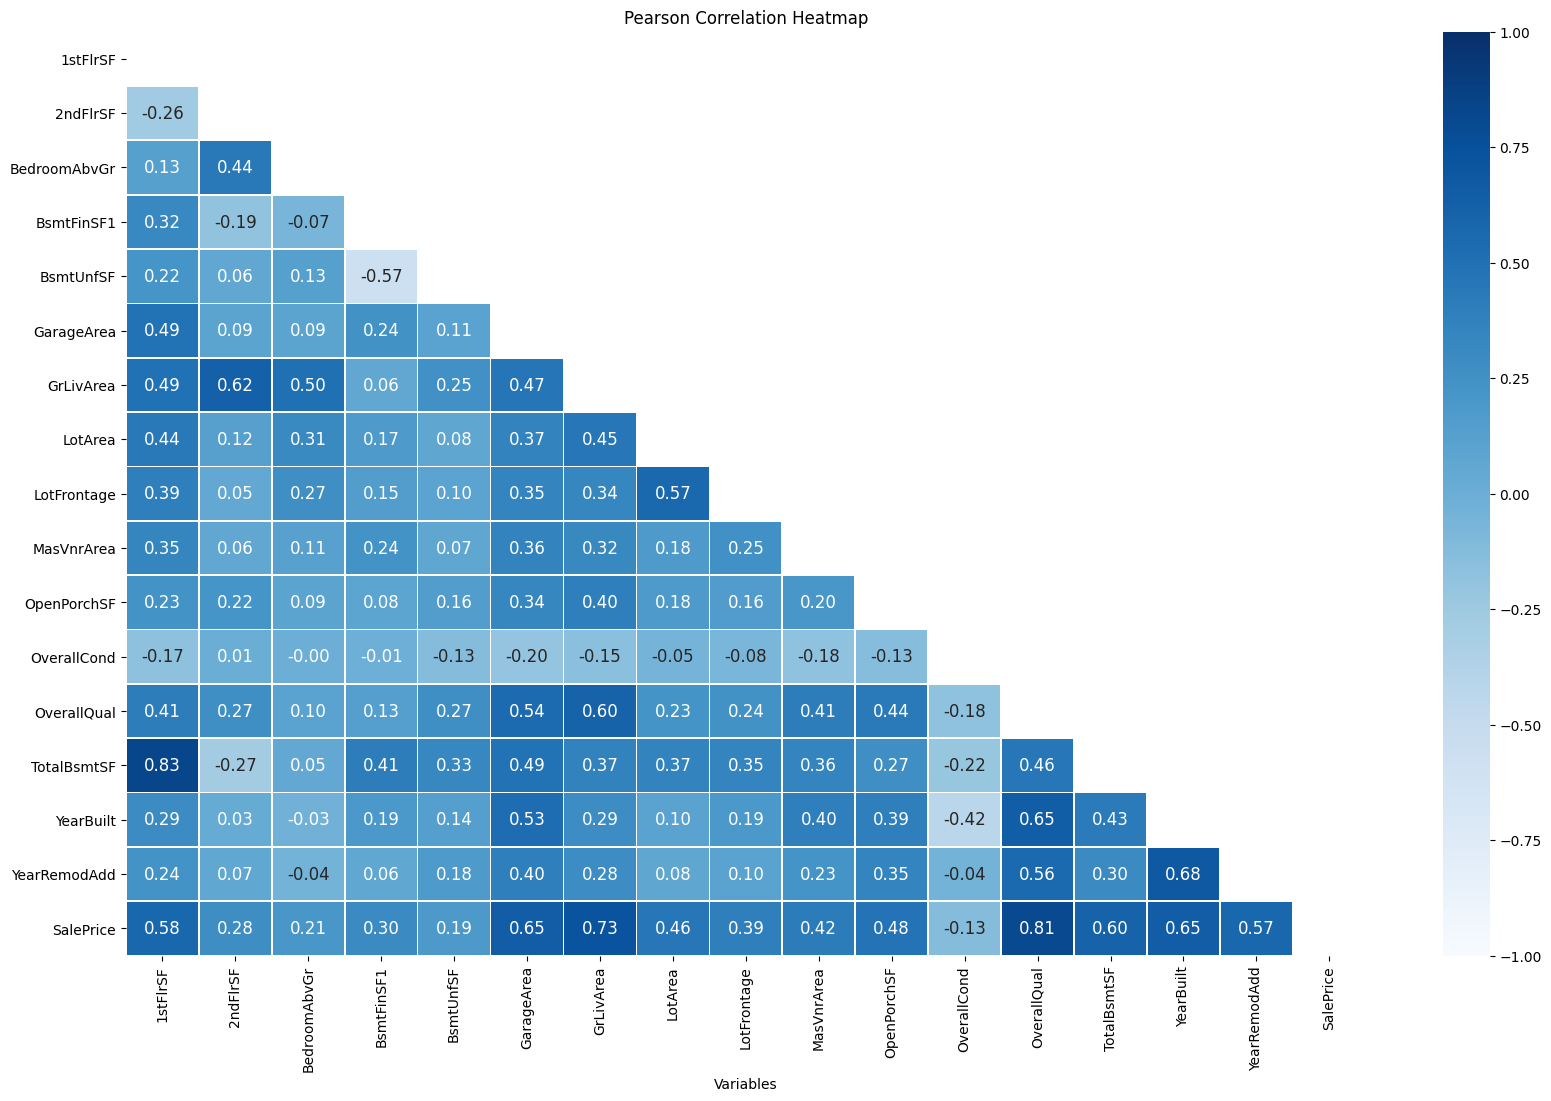

Saved heatmap to docs/plots/heatmap_corr_spearman.png


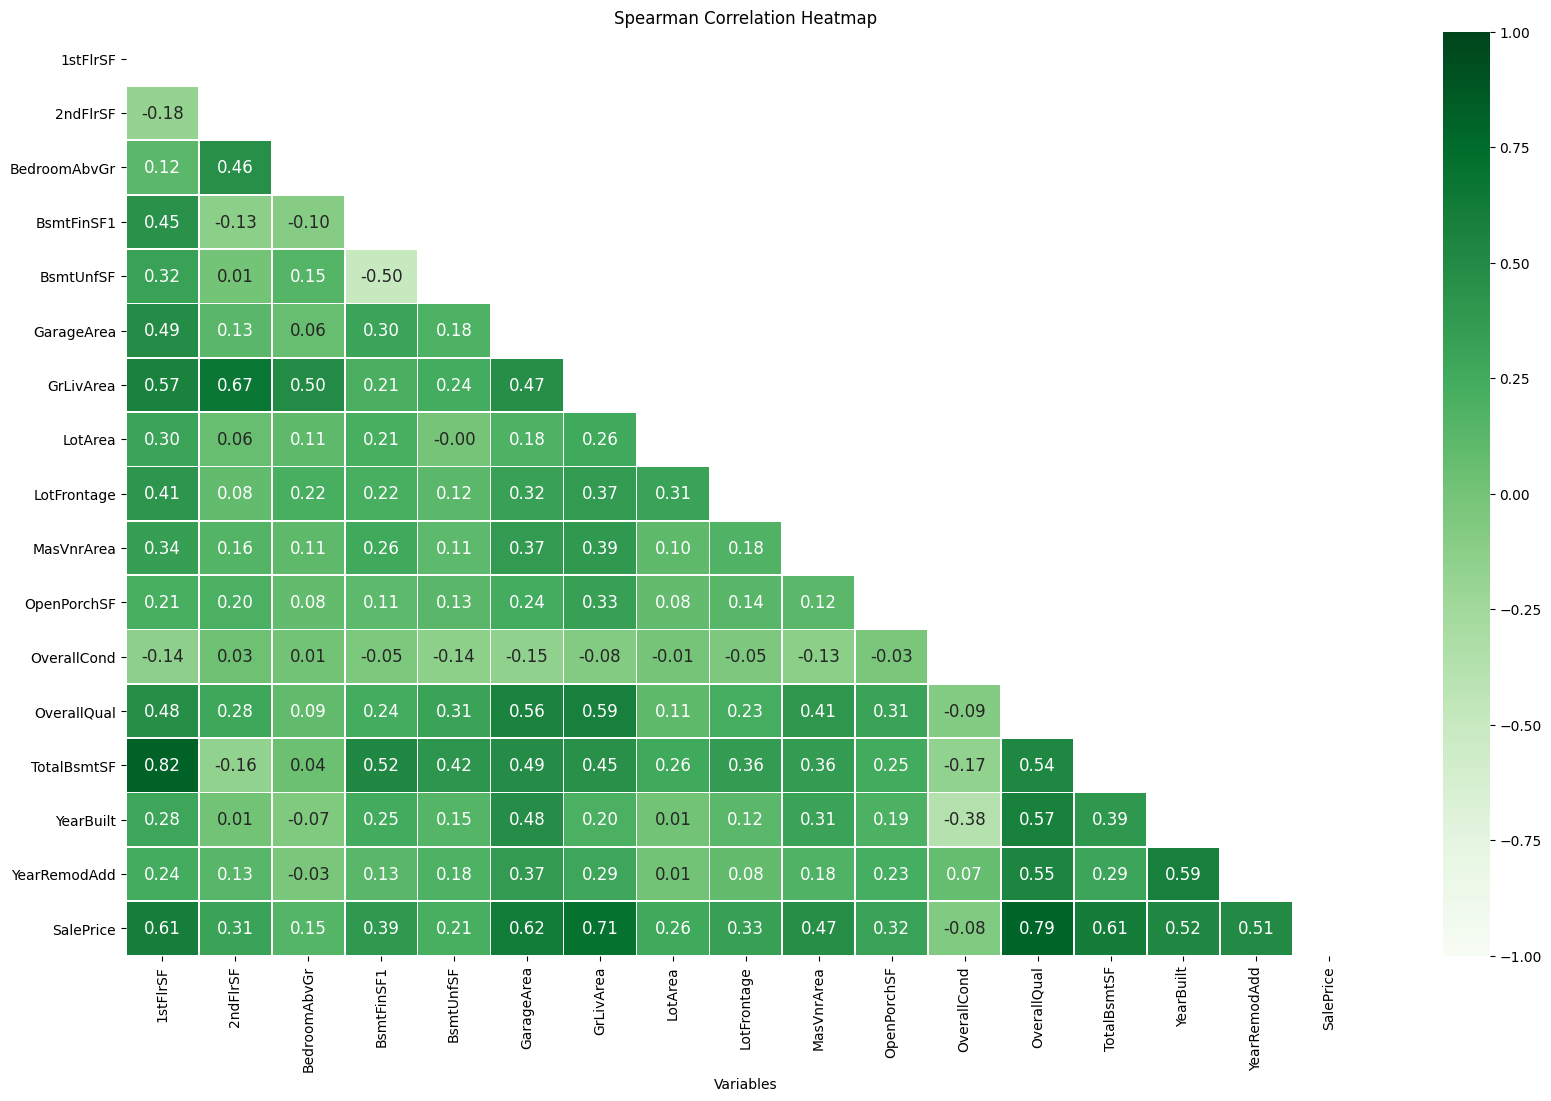

Saved heatmap to docs/plots/heatmap_predictive_power_score_heatmap.png


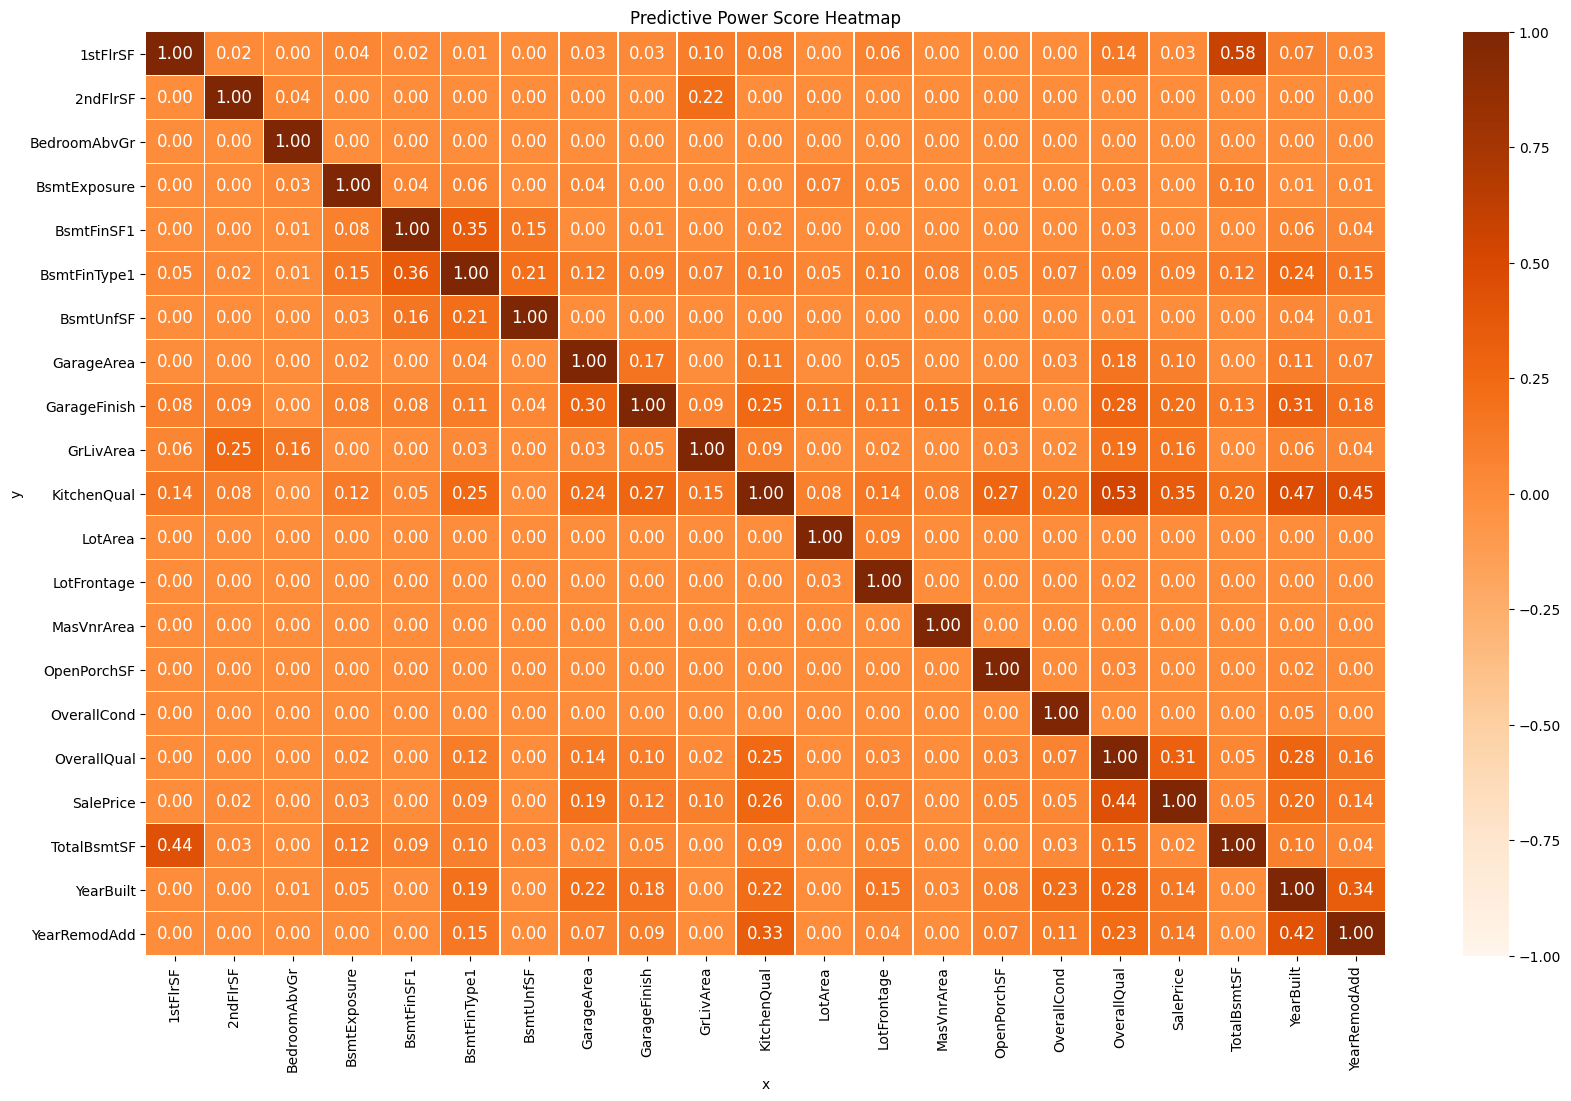

In [28]:
show_heatmaps(df_pearson, df_spearman, df_pps, corr_thresh=0.4, pps_thresh=0.2, size=(20, 12), annot_size=12)


In [29]:
# Calculate Spearman and Pearson correlations with 'SalePrice'
corr_spearman = df_encoded.corr(method='spearman')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(10)
corr_pearson = df_encoded.corr(method='pearson')['SalePrice'].sort_values(key=abs, ascending=False)[1:].head(10)

# Display the correlations
print("Top 10 Spearman Correlations with SalePrice:\n", corr_spearman)
print("\nTop 10 Pearson Correlations with SalePrice:\n", corr_pearson)

Top 10 Spearman Correlations with SalePrice:
 OverallQual       0.809829
GrLivArea         0.731310
YearBuilt         0.652682
GarageArea        0.649379
TotalBsmtSF       0.602725
KitchenQual_TA   -0.581803
1stFlrSF          0.575408
YearRemodAdd      0.571159
KitchenQual_Gd    0.478583
OpenPorchSF       0.477561
Name: SalePrice, dtype: float64

Top 10 Pearson Correlations with SalePrice:
 OverallQual       0.790982
GrLivArea         0.708624
GarageArea        0.623431
TotalBsmtSF       0.613581
1stFlrSF          0.605852
YearBuilt         0.522897
KitchenQual_TA   -0.519298
YearRemodAdd      0.507101
KitchenQual_Ex    0.504094
MasVnrArea        0.472614
Name: SalePrice, dtype: float64


In [30]:
# Define the number of top features to consider
top_n = 10

# Merge the top features from Pearson and Spearman correlations to avoid duplication
merged_features = set(corr_pearson.head(top_n).index) | set(corr_spearman.head(top_n).index)

# Convert the set to a list
top_features = list(merged_features)
print("\nMerged Top Features from Pearson and Spearman Correlations:\n", top_features)


Merged Top Features from Pearson and Spearman Correlations:
 ['MasVnrArea', 'KitchenQual_TA', '1stFlrSF', 'OpenPorchSF', 'OverallQual', 'KitchenQual_Gd', 'YearRemodAdd', 'TotalBsmtSF', 'GrLivArea', 'GarageArea', 'YearBuilt', 'KitchenQual_Ex']


* We focus on the top features, the top features and their relationship to the house sale prices

In [31]:
top_feat_to_consider = ['TotalBsmtSF', 'YearRemodAdd', 'GrLivArea', 'OverallQual', 'KitchenQual_TA', 'GarageArea', 'KitchenQual_Gd', '1stFlrSF', 'KitchenQual_Ex', 'GarageFinish_Unf', 'YearBuilt', 'MasVnrArea']
top_feat_to_consider

['TotalBsmtSF',
 'YearRemodAdd',
 'GrLivArea',
 'OverallQual',
 'KitchenQual_TA',
 'GarageArea',
 'KitchenQual_Gd',
 '1stFlrSF',
 'KitchenQual_Ex',
 'GarageFinish_Unf',
 'YearBuilt',
 'MasVnrArea']

---

## EDA on selected variables

In [32]:
df_eda = df.filter(top_feat_to_consider + ['SalePrice'])
df_eda.head()

,TotalBsmtSF,YearRemodAdd,GrLivArea,OverallQual,GarageArea,1stFlrSF,YearBuilt,MasVnrArea,SalePrice
0,856,2003,1710,7,548,856,2003,196.0,208500
1,1262,1976,1262,6,460,1262,1976,0.0,181500
2,920,2002,1786,7,608,920,2001,162.0,223500
3,756,1970,1717,7,642,961,1915,0.0,140000
4,1145,2000,2198,8,836,1145,2000,350.0,250000


## Target Analysis

### Distribution of Sales Price
* This cell does the following:

* Checking and Creating a Directory: It checks if a directory named 'visualizations' exists and creates it if it doesn't. This step ensures that there's a designated place to save plot images.

* Plotting and Saving Histogram: The cell defines and utilizes a function, visualize_distribution, to plot the distribution of a specified variable ('SalePrice') from a given DataFrame (df). This function plots a histogram with styling and customization, then saves the generated plot as a PNG file in the 'visualizations' directory.

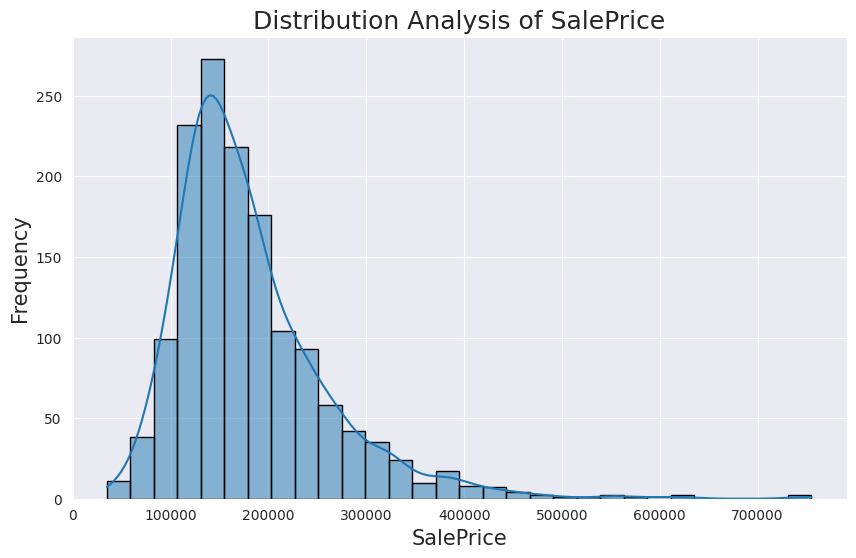

In [33]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Directory where the plot will be saved
save_dir = 'visualizations'

# Check if the directory exists, and create it if it doesn't
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

def visualize_distribution(data, variable, save_dir, figsize=(10, 6)):
    """
    Plots and saves the distribution of a specified variable in the given DataFrame.
    """
    sns.set_style('darkgrid')
    plt.figure(figsize=figsize)
    sns.histplot(data=data, x=variable, bins=30, edgecolor='black', kde=True)
    plt.title(f"Distribution Analysis of {variable}", fontsize=18)
    plt.xlabel(f"{variable}", fontsize=15)
    plt.ylabel("Frequency", fontsize=15)
    plt.grid(True)
    plt.savefig(f'{save_dir}/histogram_{variable}.png', bbox_inches='tight')
    plt.show()

target_variable = 'SalePrice'
visualize_distribution(df, target_variable, save_dir)
time = ['YearBuilt', 'YearRemodAdd']

### Bivariate Plots

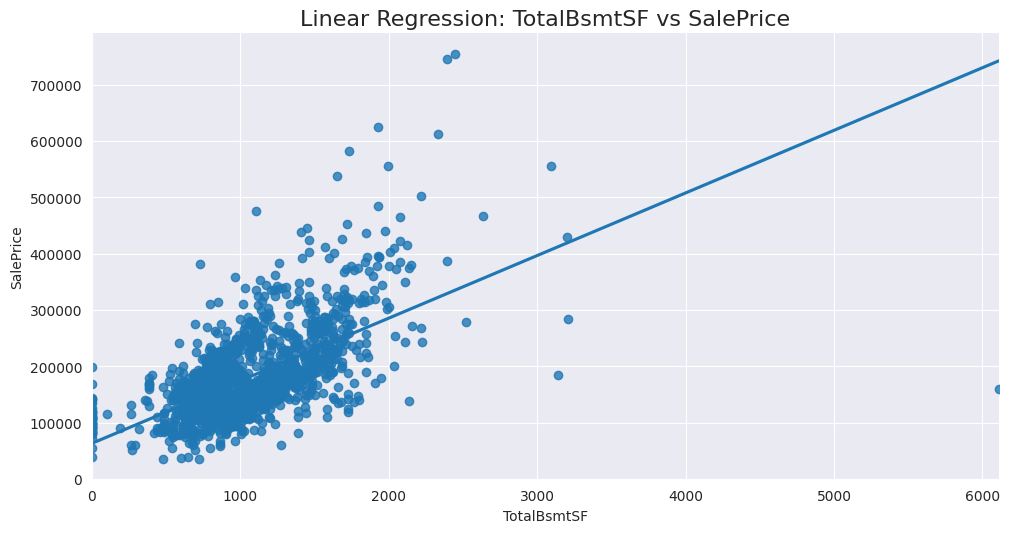

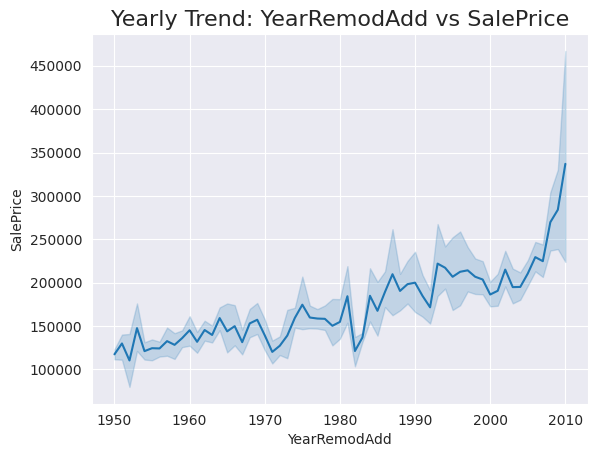

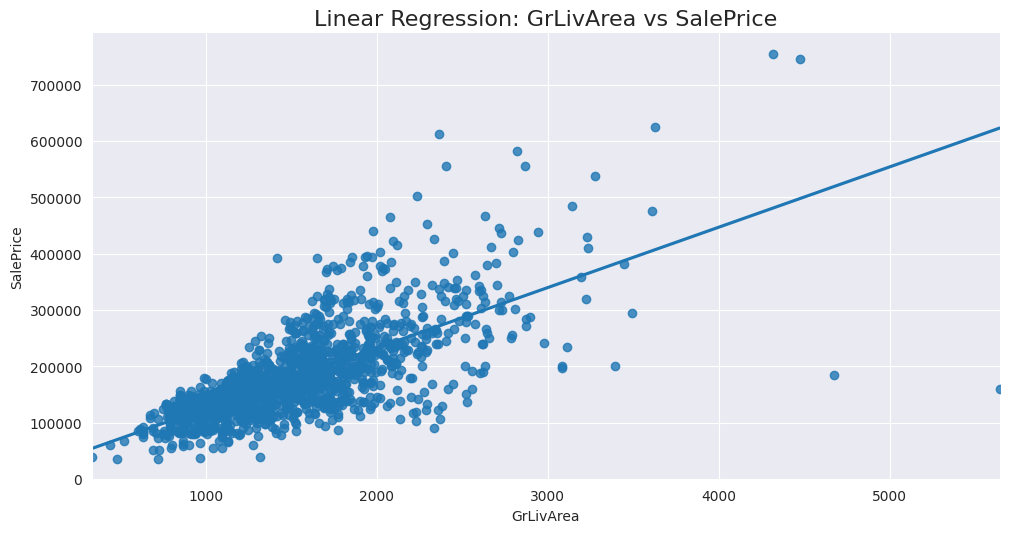

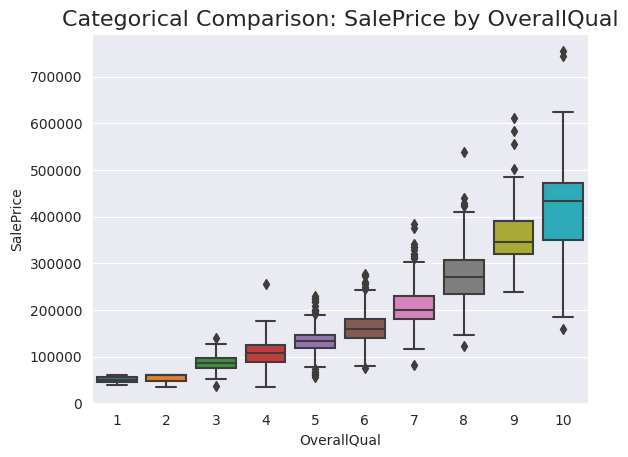



Column KitchenQual_TA not found in df_eda.


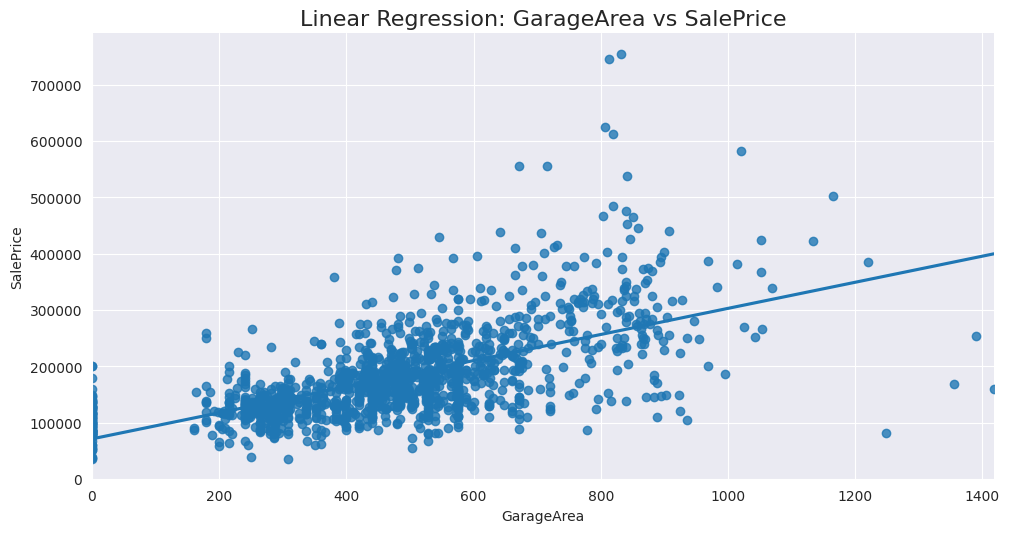



Column KitchenQual_Gd not found in df_eda.


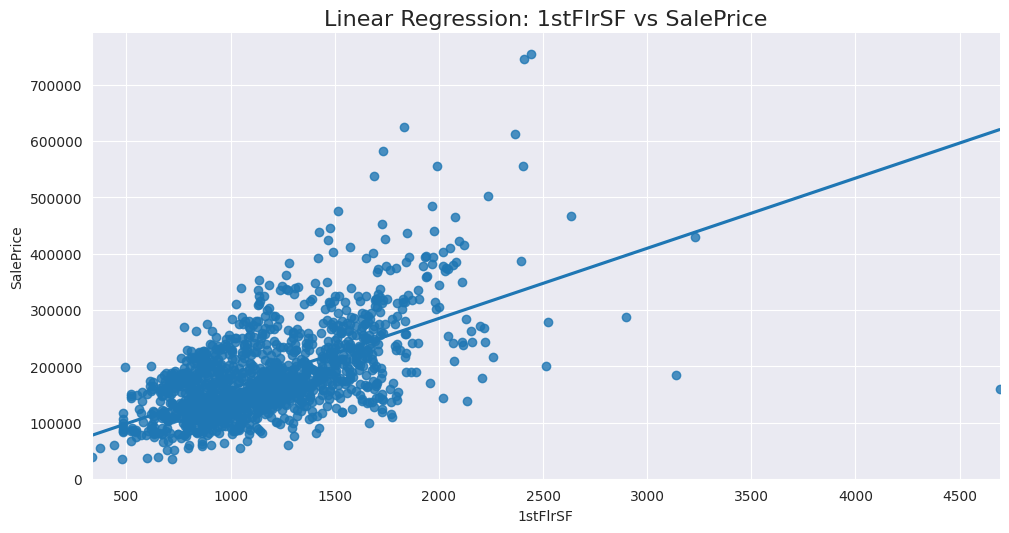



Column KitchenQual_Ex not found in df_eda.
Column GarageFinish_Unf not found in df_eda.


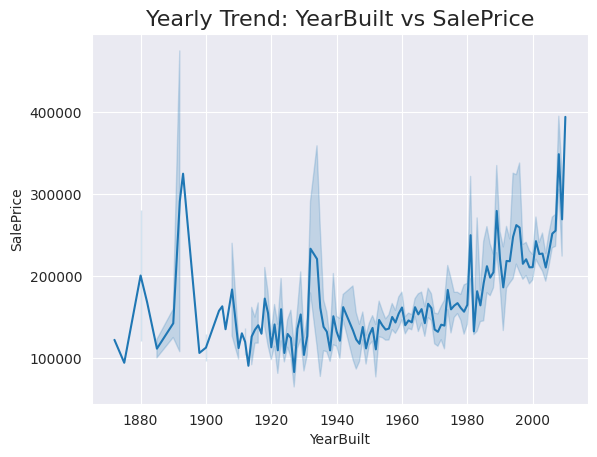

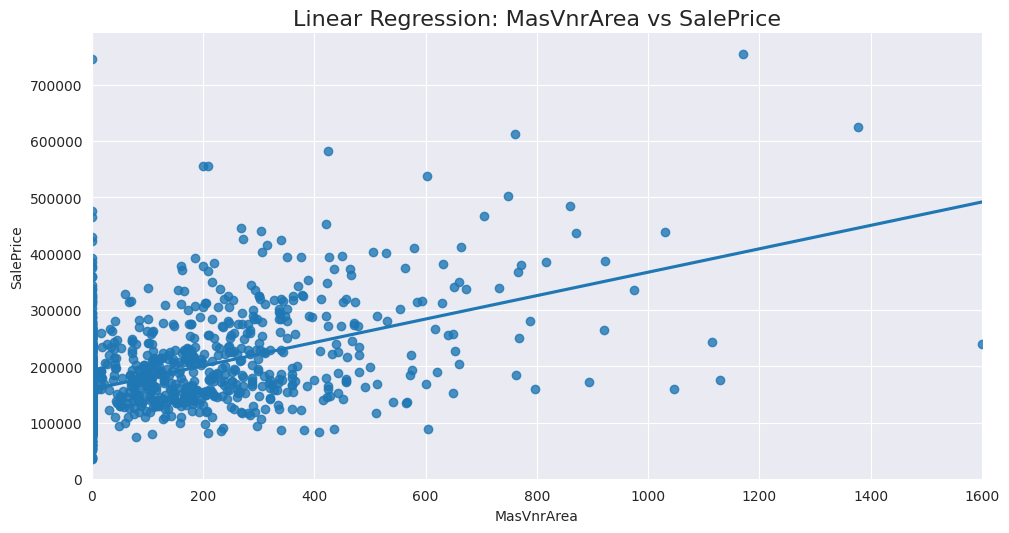

In [34]:
def plot_regression(df, feature, target_variable):
    """
    Generates and saves a linear regression plot between a feature and the target variable.
    """
    sns.lmplot(data=df, x=feature, y=target_variable, height=5, aspect=2, ci=None)
    plt.title(f"Linear Regression: {feature} vs {target_variable}", fontsize=16)
    plt.savefig(f'visualizations/regression_{feature}_vs_{target_variable}.png', bbox_inches='tight')
    plt.show()

def plot_yearly_trend(df, feature, target_variable):
    """
    Creates and saves a line plot showing the yearly trend of the target variable.
    """
    sns.lineplot(data=df, x=feature, y=target_variable)
    plt.title(f"Yearly Trend: {feature} vs {target_variable}", fontsize=16)
    plt.savefig(f'visualizations/yearly_trend_{feature}_vs_{target_variable}.png', bbox_inches='tight')
    plt.show()

def plot_categorical_comparison(df, feature, target):
    """
    Generates and saves a box plot to compare the target variable across different categories.
    """
    sns.boxplot(data=df, x=feature, y=target_variable)
    plt.title(f"Categorical Comparison: {target_variable} by {feature}", fontsize=16)
    plt.savefig(f'visualizations/categorical_{feature}_vs_{target_variable}.png', bbox_inches='tight')
    plt.show()

# Iterating through variables to plot
for variable in top_feat_to_consider:
    if variable not in df_eda.columns:
        print(f"Column {variable} not found in df_eda.")
        continue

    if df_eda[variable].nunique() <= 10:
        plot_categorical_comparison(df_eda, variable, target_variable)
    else:
        if variable in time:
            plot_yearly_trend(df_eda, variable, target_variable)
        else:
            plot_regression(df_eda, variable, target_variable)
    print("\n")

* In analyzing the plots, I noticed a consistent trend where features with higher values correspond to increased property values. This was evident in different types of plots, such as linear regression, box, and line plots, especially with variables related to time.

* I also observed that, similar to the target distribution exhibiting extreme values, the features too have outliers. This is an important consideration for my analysis, as outliers can greatly affect the accuracy of predictions.

* To address this, I plan to manage these outliers in the feature engineering phase of my work. My aim is to refine the data for better modeling. This will involve techniques like capping, transformations, or even removal of extreme outliers, depending on their impact and relevance. By doing so, I'm striving to enhance the reliability of my model and ensure it accurately reflects the trends in property values. This step is crucial in my analysis process to mitigate the potential skewing effects of outliers on the model's predictions.

---

# Conclusions and Next steps

* We made various studies that points to that the quality and the house price is having influencing factors. Next we perform Feature engineering.